In [32]:
%pip install yfinance
%pip install matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.style.use('seaborn')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
tickers = 'AAPL,TSLA,MSFT,GM,BCS,QCOM,PTR,VALE,GS,CI,ENB,CB,LFC,MUFG,NVDA,ASML,ADBE,SONY,AMD,TXN,F,'
indices = 'SPY,'

md = yf.download(
    tickers = indices + tickers,
    group_by='ticker',
    start='2020-05-19', end='2021-05-19',
    interval = '1d',
    auto_adjust = True,
    threads = True
    )

print(f'Downloaded {len(md)} days of market data for indices : {indices} and tickers : {tickers}')

md['SPY'].tail()
print(f"Index : {md.index[:5]}...")
print(f"Columns : {md.columns[:5]}...")



[*********************100%***********************]  22 of 22 completed
Downloaded 253 days of market data for indices : SPY, and tickers : AAPL,TSLA,MSFT,GM,BCS,QCOM,PTR,VALE,GS,CI,ENB,CB,LFC,MUFG,NVDA,ASML,ADBE,SONY,AMD,TXN,F,
Index : DatetimeIndex(['2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22'],
              dtype='datetime64[ns]', name='Date', freq=None)...
Columns : MultiIndex([('AMD',   'Open'),
            ('AMD',   'High'),
            ('AMD',    'Low'),
            ('AMD',  'Close'),
            ('AMD', 'Volume')],
           )...


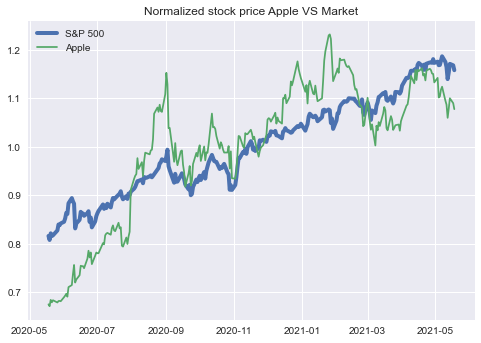

In [34]:
def plotNormalized(data, labelName, **kwargs):
    plt.plot(data / data.mean(), label = labelName, **kwargs)

plotNormalized(md['SPY'].Close, "S&P 500", linewidth = 4)
plotNormalized(md['AAPL'].Close, "Apple")
#plotNormalized(md['AMD'].Close, "AMD")
#plotNormalized(md['GM'].Close, "General Motors")
#plotNormalized(md['TSLA'].Close, "Tesla")
#plotNormalized(md['MUFG'].Close, "Mitsubishi UFJ Financial")
plt.title('Normalized stock price Apple VS Market')
plt.legend()
plt.show()


In [35]:
def getPriceAndReturn(md, **kwargs):
    priceField = 'Close'
    prices = pd.DataFrame()
    returns = pd.DataFrame()
    for ticker, kind in md.columns:
        if kind == priceField:
            prices[ticker] = md[ticker][[priceField]].values.reshape(1, -1).ravel()
            returns[ticker] = prices[ticker].pct_change(**kwargs)
    return prices, returns

prices, returns = getPriceAndReturn(md)

print(prices['SPY'].head())
print(returns['SPY'].head())



0    290.343842
1    287.361664
2    292.243408
3    290.225769
4    290.776947
Name: SPY, dtype: float64
0         NaN
1   -0.010271
2    0.016988
3   -0.006904
4    0.001899
Name: SPY, dtype: float64


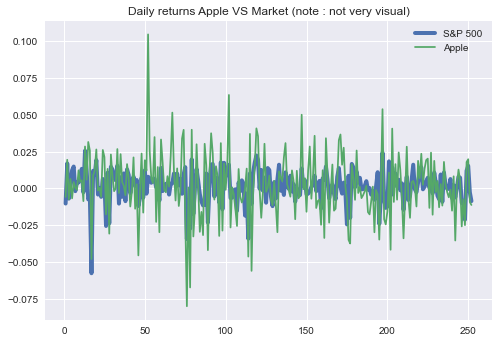

In [36]:
plt.plot(returns['SPY'], label = 'S&P 500', linewidth = 4)
plt.plot(returns['AAPL'], label = 'Apple')
plt.title("Daily returns Apple VS Market (note : not very visual)")
plt.legend()
plt.show()

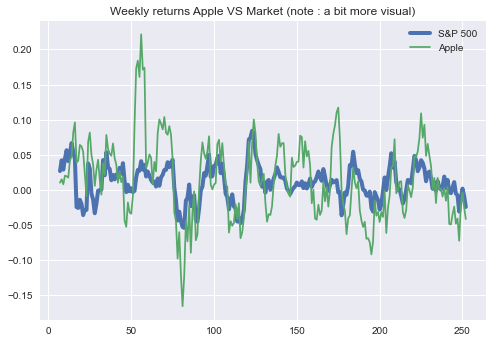

In [37]:
weeklyPrices, weeklyReturns = getPriceAndReturn(md, periods=7)

plt.plot(weeklyReturns['SPY'], label = 'S&P 500', linewidth = 4)
plt.plot(weeklyReturns['AAPL'], label = 'Apple')
plt.title("Weekly returns Apple VS Market (note : a bit more visual)")
plt.legend()
plt.show()


In [38]:
def getStats(prices, returns):
    mean = []
    std = []
    sharpe = []
    totReturn = []

    for ticker in returns.columns:
        pr = prices[ticker]
        ret = returns[ticker]

        totReturn.append((pr.iloc[-1] - pr.iloc[0]) / pr.iloc[0])
        mean.append(ret.mean())
        std.append(ret.std())

        sharpe.append(mean[-1] / std[-1] * (252**0.5)) #TODO consider adding risk free rate

    return pd.DataFrame.from_dict(
        {'DailyMean' : mean, 'DailyStd' : std, 'AnualSR' : sharpe, 'TotalReturn' : totReturn},
        orient='index', columns=returns.columns)

stats = getStats(prices, returns)

print(f"Daily return SPY mean : {stats['SPY']['DailyMean']}")
print(f"Daily return SPY std  : {stats['SPY']['DailyStd']}")

print(f"Basic return stats (mean, std, sharpe ratio, total return) :\n{stats}")

Daily return SPY mean : 0.0014474968820360192
Daily return SPY std  : 0.010791323551446576
Basic return stats (mean, std, sharpe ratio, total return) :
                  AMD      NVDA       ENB        GM       SPY      SONY  \
DailyMean    0.001694  0.002248  0.001179  0.003590  0.001447  0.001725   
DailyStd     0.030751  0.027271  0.015030  0.027091  0.010791  0.018099   
AnualSR      0.874549  1.308776  1.245412  2.103608  2.129331  1.512970   
TotalReturn  0.363620  0.603992  0.308307  1.252721  0.418801  0.482753   

                    F       PTR      QCOM      ASML  ...      VALE      MSFT  \
DailyMean    0.003638  0.001146  0.002320  0.003211  ...  0.004174  0.001280   
DailyStd     0.026592  0.022005  0.026079  0.023965  ...  0.024523  0.017525   
AnualSR      2.171447  0.826531  1.412246  2.126632  ...  2.701746  1.159051   
TotalReturn  1.286252  0.256974  0.648640  1.087622  ...  1.650893  0.327944   

                  TXN      ADBE      AAPL       BCS        CB      MUFG

No handles with labels found to put in legend.


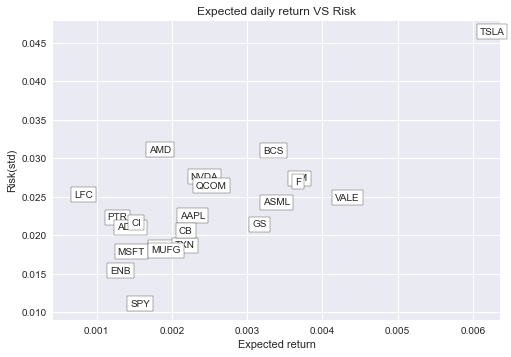

In [39]:
# See more on visualisation : https://kanoki.org/2019/09/16/dataframe-visualization-with-pandas-plot/
transposedStats = stats.transpose()
plt.scatter(transposedStats['DailyMean'], transposedStats['DailyStd'])
for ticker in stats.columns:
    x = stats[ticker]['DailyMean']
    y = stats[ticker]['DailyStd']
    plt.annotate(
        ticker,
        (x, y),
        bbox=dict(boxstyle="square", fc="w"))

plt.legend()
plt.xlabel('Expected return')
plt.ylabel('Risk(std)')
plt.title("Expected daily return VS Risk")
plt.show()


In [40]:
def getCovAndCorr(returns, stats):
    cov = []
    corr = []

    for i in range(len(returns.columns)):
        covColumn = []
        corrColumn = []
        
        iname = returns.columns[i]
        for j in range(i):
            covColumn.append(cov[j][i])
            corrColumn.append(corr[j][i])
        iStd = stats[iname]["DailyStd"]
        covColumn.append(iStd * iStd)
        corrColumn.append(1)
        for j in range(i+1, len(returns.columns)):
            jname = returns.columns[j]
            jStd = stats[jname]["DailyStd"]
            tickerCov = returns[iname].cov(returns[jname])
            covColumn.append(tickerCov)
            corrColumn.append(tickerCov / (iStd * jStd))
        cov.append(covColumn)
        corr.append(corrColumn)

    covDf = pd.DataFrame(cov, index = returns.columns, columns = returns.columns)
    corrDf = pd.DataFrame(corr, index = returns.columns, columns = returns.columns)
    return covDf, corrDf

cov, corr = getCovAndCorr(returns, stats)

print(f"Correlation matrix :\n{corr}\n")
print(f"Test Correlation TSLA/MSFT: {returns['TSLA'].cov(returns['MSFT'])/(stats['TSLA']['DailyStd'] * stats['MSFT']['DailyStd'])}")
'''
print(f"Covariance :\n{cov}\n")
print(f"Test Covariance TSLA/MSFT: {returns['TSLA'].cov(returns['MSFT'])}")
print(f"Covarience SPY column :\n{cov['SPY']}")
print(f"Covarience TSLA row :\n{cov.loc['TSLA']}")
print(f"corr.loc['SPY','TSLA'] : {corr.loc['SPY','TSLA']}")
'''
print(f"corr.loc['TSLA','SPY'] : {corr.loc['TSLA','SPY']}")


Correlation matrix :
           AMD      NVDA       ENB        GM       SPY      SONY         F  \
AMD   1.000000  0.696549  0.165534 -0.019413  0.461708  0.263708  0.017970   
NVDA  0.696549  1.000000  0.128385  0.072813  0.591228  0.358647  0.034789   
ENB   0.165534  0.128385  1.000000  0.398182  0.544283  0.163934  0.416661   
GM   -0.019413  0.072813  0.398182  1.000000  0.456841  0.153262  0.737883   
SPY   0.461708  0.591228  0.544283  0.456841  1.000000  0.382444  0.476156   
SONY  0.263708  0.358647  0.163934  0.153262  0.382444  1.000000  0.141868   
F     0.017970  0.034789  0.416661  0.737883  0.476156  0.141868  1.000000   
PTR   0.060758  0.105026  0.447221  0.249896  0.360997  0.088298  0.220547   
QCOM  0.490682  0.574012  0.249886  0.203877  0.598438  0.343778  0.174750   
ASML  0.438955  0.650574  0.209040  0.230843  0.608903  0.351065  0.227765   
TSLA  0.391549  0.514542  0.121175  0.066320  0.464253  0.264853  0.071104   
GS    0.051498  0.085137  0.494312  0.50326

In [41]:
def getAlphaBetaBenchmark(indices, tickers, cov, stats):
    #TODO consider adding risk free rate
    benchmark = {}
    for index in indices:
        alpha = []
        beta = []
        for ticker in tickers:
            indexVarience = cov[index][index]
            indexTickerCovarience = cov[index][ticker]
            indexTickerBeta = indexTickerCovarience / indexVarience
            indexTickerAlpha = stats[ticker]['TotalReturn'] - indexTickerBeta * stats[index]['TotalReturn']
            beta.append(indexTickerBeta)
            alpha.append(indexTickerAlpha)

        benchmark[index] = pd.DataFrame.from_dict({'Alpha' : alpha, 'Beta' : beta}, orient='index', columns=tickers)
    return benchmark

abBench = getAlphaBetaBenchmark(
    list(filter(None, indices.split(','))),
    list(filter(None, tickers.split(','))),
    cov, stats)

print(f"Alpa/Beta for SPY benchmark :\n{abBench['SPY']}")

Alpa/Beta for SPY benchmark :
           AAPL      TSLA      MSFT        GM       BCS      QCOM       PTR  \
Alpha  0.015872  1.721312 -0.172086  0.772418  0.437016  0.042966 -0.051308   
Beta   1.385885  1.981545  1.193959  1.146854  1.344935  1.446212  0.736107   

           VALE        GS        CI  ...        CB       LFC      MUFG  \
Alpha  1.165004  0.576772 -0.015219  ...  0.230395 -0.270370  0.156281   
Beta   1.160191  1.125695  0.909719  ...  0.905203  0.901178  0.783987   

           NVDA      ASML      ADBE      SONY       AMD       TXN         F  
Alpha -0.021738  0.521300 -0.200919  0.214130 -0.187396  0.064978  0.794848  
Beta   1.494100  1.352246  1.210740  0.641412  1.315700  1.286491  1.173361  

[2 rows x 21 columns]


No handles with labels found to put in legend.


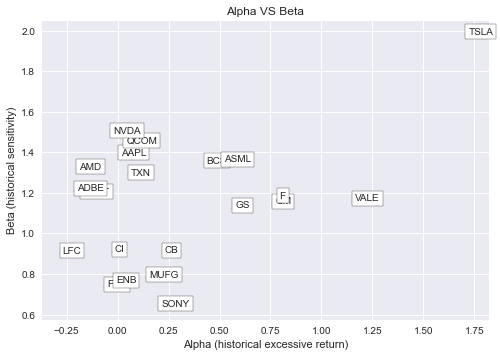

In [42]:
AB = abBench['SPY']
transposedAB = AB.transpose()
plt.scatter(transposedAB['Alpha'], transposedAB['Beta'])

for ticker in AB.columns:
    x = AB[ticker]['Alpha']
    y = AB[ticker]['Beta']
    plt.annotate(
        ticker,
        (x, y),
        bbox=dict(boxstyle="square", fc="w"))

plt.legend()
plt.xlabel('Alpha (historical excessive return)')
plt.ylabel('Beta (historical sensitivity)')
plt.title("Alpha VS Beta")
plt.show()
